# Input Representation

## Introduction

In this project we improve handwriting. Initial representation of handwriting is usually done by recording the raw coordinates on the touch surface on which text is written. However, before actually using this data we need to think about how we want to represent it. This needs to be done to make sure representation is consistent over different devices, that the data is represented in a memmory efficient manner and such that the data can be used effectively. Therefore, in this notebook we will look at two different representations. The first is coordinates, but with normalisation and resampeling applied. The second is bezier curves that are fitted onto the data.

## Retrieving the data

The data we will be using as an example is stored in a csv file. In this case we will use the file to which the program AutoWrite writes it output.

In [1]:
path = "./input_example.npy"

Next we will retrieve this data using numpy which will will also use for the rest of our data manipulation.

In [2]:
import numpy as np

In [3]:
raw_strokes = np.load(path, allow_pickle=True)
print(raw_strokes.shape)
print(raw_strokes[0, 0])

(6, 114, 3)
[1.70000000e+02 2.72000000e+02 1.65482608e+12]


So in this case there are seven strokes with a maximum length of 99 data points. Each data point consists of an x- and y-coordinate and a timestamp.

We can plot what these strokes look like. These strokes are ragged arrays, so we only plot the coordinates that do not have a negative timestamp.

In [4]:
from matplotlib import pyplot as plt

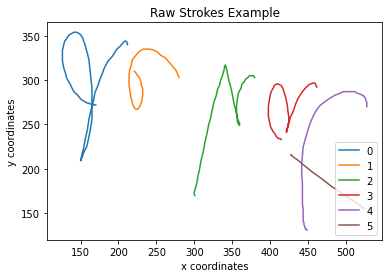

In [5]:
def plot_strokes(strokes, plot_name):
    plt.title(plot_name)
    plt.xlabel("x coordinates")
    plt.ylabel("y coordinates")

    for i, stroke in enumerate(strokes):
        plt.plot(stroke[:, 0][stroke[:, 2] >= 0], stroke[:, 1][stroke[:, 2] >= 0], label=str(i))

    plt.legend()
    plt.show()
    
plot_strokes(raw_strokes, "Raw Strokes Example")

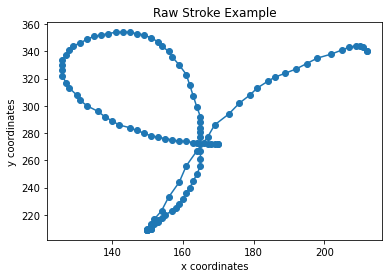

In [6]:
def plot_stroke(stroke, plot_name):
    plt.title(plot_name)
    plt.xlabel("x coordinates")
    plt.ylabel("y coordinates")

    plt.plot(stroke[:, 0][stroke[:, 2] >= 0], stroke[:, 1][stroke[:, 2] >= 0])
    plt.scatter(stroke[:, 0][stroke[:, 2] >= 0], stroke[:, 1][stroke[:, 2] >= 0])

    plt.show()
    
plot_stroke(raw_strokes[0], "Raw Stroke Example")

As you can see the y coordinates are flipped. So next we the input is normalized.

## Normalizing the data

First we will remove datapoints with the same (x,y) coordinates.

In [7]:
ustrokes = [np.unique(stroke[:, :2], return_index=True, axis=0)[1] for stroke in raw_strokes]
max_stroke_len = max(len(r) for r in ustrokes)

unique_strokes = np.zeros((len(ustrokes), max_stroke_len, 3))
unique_strokes[:, :, 2] -= 1

for i, row in enumerate(ustrokes):
    unique_strokes[i, :len(row)] = raw_strokes[i, np.sort(row)]

To normalize this data, we will first flip the y-axis, next we will move the starting coordinate to $(0, 0)$, after that we will scale the y and x axis linearly so the y values span a range $[0,1]$ and lastly we make the timestamps relative.

We can simply flip the strokes around by multiply the y-coordinates by $-1$.

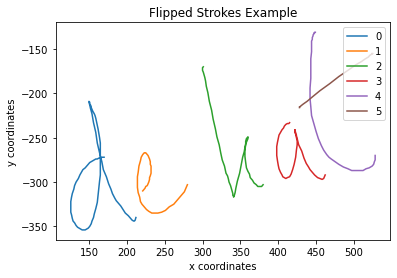

In [8]:
flipped_strokes = unique_strokes.copy()

non_ragged = unique_strokes[:, :, 2] >= 0

flipped_strokes[:, :, 1][non_ragged] *= -1
plot_strokes(flipped_strokes, "Flipped Strokes Example")

Next we move the initial x-value and y-value to $0$. We do this by subtracting the initial coordinates from all coordinates.

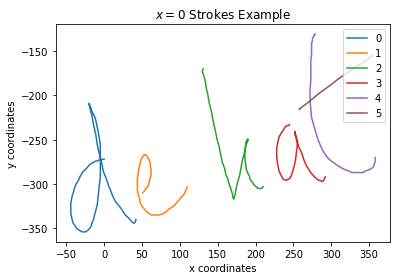

In [9]:
x0_strokes = flipped_strokes.copy()

x0_strokes[:, :, 0][non_ragged] -= x0_strokes[0, 0, 0]

plot_strokes(x0_strokes, "$x=0$ Strokes Example")

Now we scale both the x- and y-axis linearly so all y-values values in the range $[0,1]$. We do this by first moving the lowest y values to $y=0$ and then scaling the other values by the dividing them with the highest y value.

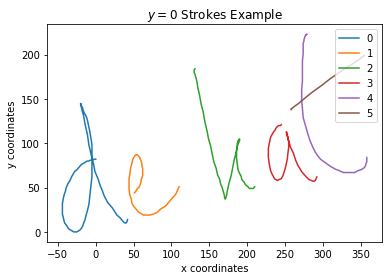

In [10]:
y0_strokes = x0_strokes.copy()

y0_strokes[:, :, 1][non_ragged] -= np.amin(y0_strokes[:, :, 1])

plot_strokes(y0_strokes, "$y=0$ Strokes Example")

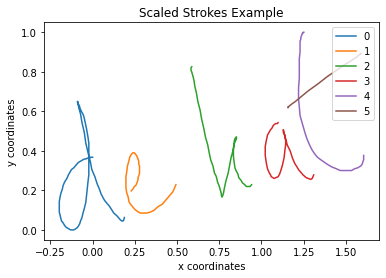

In [11]:
scaled_strokes = y0_strokes.copy()

scaled_strokes[:, :, :2][non_ragged] /= np.amax(scaled_strokes[:, :, 1])

plot_strokes(scaled_strokes, "Scaled Strokes Example")

With this we have finished normalizing the data. These operations can be put together for optimization, since they are executed some signs are turned around.

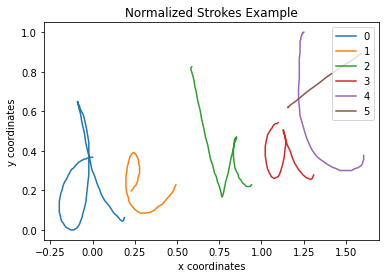

In [12]:
def normalize_strokes(data):
    ustrokes = [np.unique(stroke[:, :2], return_index=True, axis=0)[1] for stroke in data]
    max_stroke_len = max(len(r) for r in ustrokes)

    normalized = np.zeros((len(ustrokes), max_stroke_len, 3))
    normalized[:, :, 2] -= 1

    for i, row in enumerate(ustrokes):
        normalized[i, :len(row)] = data[i, np.sort(row)]

    non_ragged = normalized[:, :, 2] >= 0
    normalized[non_ragged] -= [normalized[0, 0, 0], np.amax(normalized[:, :, 1]), normalized[0, 0, 2]]
    normalized[non_ragged] /= [-np.amin(normalized[:, :, 1]), np.amin(normalized[:, :, 1]), 1]

    return normalized

normalized_strokes = normalize_strokes(raw_strokes)
plot_strokes(normalized_strokes, "Normalized Strokes Example")

## Raw Touch Points

The most basic input representation for online handwriting recognition are raw touch points. To use the input coordinates and timestamps as raw touch point we will first resample each stroke. Then the arrays containing strokes are collapsed to make a single sequence, an extra parameter is then added for noting when a stroke starts. This parameter is set to 1 if the point is a starting point for a stroke, else it is $0$.

Interpolating is simply done linearly. So if the distant between two following coordinates is to large, a number of points such that the distance between all the points that span the stroke is 0.05, is linearly interpolated.

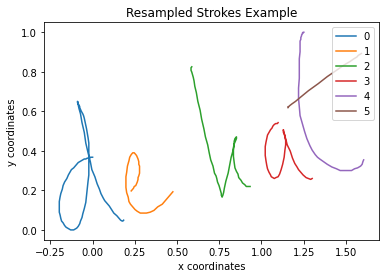

In [13]:
def sample_line(p0, p1, delta=0.05):
    l = ((p1[0]-p0[0])**2 + (p1[1]-p0[1])**2)**0.5
    num = int(l/delta)
    
    if num == 0:
        return [p0]
    
    sampled_xs = np.linspace(p0[0], p1[0], num)
    sampled_ys = np.linspace(p0[1], p1[1], num)
    sampled_timestamps = np.linspace(p0[2], p1[2], num)

    return np.stack((sampled_xs, sampled_ys, sampled_timestamps), axis=1).tolist()

def resample_stroke(stroke):
    resampled_stroke = []
    
    for i, _ in enumerate(stroke[stroke[:, 2] >= 0][:-1]):
        resampled_stroke.extend(sample_line(stroke[i], stroke[i+1]))
        
    return resampled_stroke

def resample_strokes(strokes):
    rs = [resample_stroke(stroke) for stroke in strokes
          if resample_stroke(stroke)]

    max_stroke_len = max(len(r) for r in rs)

    rs_padded = np.zeros((len(rs), max_stroke_len, 3))
    rs_padded[:, :, 2] -= 1

    for i, row in enumerate(rs):
        rs_padded[i, :len(row)] = row
        
    return rs_padded
    
rs = resample_strokes(normalized_strokes)
plot_strokes(rs, "Resampled Strokes Example")

Lastly this array of strokes is collapsed to form one long sequence of datapoints. We now add values to show if a datapoint is a starting point for a stroke and whether the pen direction is up or down. This is combined together in one signle function that converts the input $x$ and $y$ coordinates and timestamps to the raw touch points representation. Instead of passing these values directly, we will pass on the diretion in which they change, for this reason, timestamps do not need to be normalized to start at 0.

In [14]:
def convert_to_rtps(data):
    rs = resample_strokes(normalize_strokes(data))
    rs = np.append(rs, np.zeros((rs.shape[0], rs.shape[1], 1)), axis=2)
    rs[:, 0, 3] = 1
    rtps = rs[rs[:, :, 2] >= 0].tolist()
    rtps = np.array(rtps)
    diffs = np.insert(np.diff(rtps, axis=0)[:,:3], 0, np.array([0, 0, 0]), axis=0)
    return np.append(diffs, np.expand_dims(rtps[:,3], -1), axis=1)

In [15]:
rtps = convert_to_rtps(raw_strokes)
print(rtps.shape)
print(rtps[:10])

(331, 4)
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [-4.48430493e-03  0.00000000e+00  8.00000000e+00  0.00000000e+00]
 [-4.48430493e-03  0.00000000e+00  4.00000000e+00  0.00000000e+00]
 [-4.48430493e-03  0.00000000e+00  7.00000000e+00  0.00000000e+00]
 [-4.48430493e-03 -4.48430493e-03  8.00000000e+00  0.00000000e+00]
 [-8.96860987e-03  0.00000000e+00  6.00000000e+00  0.00000000e+00]
 [-4.48430493e-03  0.00000000e+00  8.00000000e+00  0.00000000e+00]
 [-8.96860987e-03 -4.48430493e-03  8.00000000e+00  0.00000000e+00]
 [-8.96860987e-03  0.00000000e+00  9.00000000e+00  0.00000000e+00]
 [-8.96860987e-03 -4.48430493e-03  5.00000000e+00  0.00000000e+00]]


Here the datapoints representing the start of each stroke have a red color.

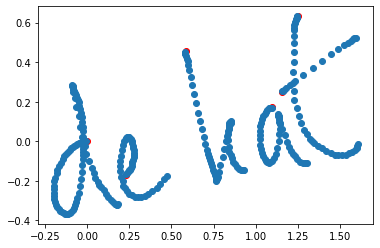

In [16]:
def plot_rtps(rtps):
    current_x = 0
    current_y = 0
    plt.scatter(current_x, current_y, c='r')
    
    for (x, y, t, s) in rtps[1:]:
        current_x += x
        current_y += y
        
        if s:
            plt.scatter(current_x, current_y, c='r')
        else:
            plt.scatter(current_x, current_y, c='#1f77b4')

        
    plt.show()
    
plot_rtps(rtps)

## Bezier Curves

### Scaling Timestamps

However, there is a more efficient representation. We can also represent the input as a number of fitted bezier curves. Each curve can represent multiple datapoints does saving memory and abstracting more complex features in the representation itself.

To do this, first the timestamps are scaled linearly to match the length of the ink. Todo this we first calculate the total length of the ink using pythagoras.

In [17]:
squared_differences = np.diff(normalized_strokes, axis=1)[:, :, :2]**2
distances = np.sum(squared_differences, axis=2)**(1/2)

# Last difference is to 0, we do not want to count this
total_length = np.sum(distances[(normalized_strokes[:, :, 2] >= 0)[:, 1:]])
print(total_length)

6.559245836787186


All timestamps are scaled so the largest timestamp is equal to this value and as we can see the last value in last stroke now has a timestamp equal to the total length.

In [18]:
scaling_factor = normalized_strokes[non_ragged][-1, 2] / total_length
print(scaling_factor)

normalized_timestamps = normalized_strokes.copy()
normalized_timestamps[:,:,2][non_ragged] /= scaling_factor

print(normalized_timestamps[-1][15:25])

759.690995579569
[[ 1.57399103  0.88340807  6.52765404]
 [ 1.58295964  0.88789238  6.53818464]
 [ 1.59192825  0.89237668  6.54871524]
 [ 1.58744395  0.89237668  6.55924584]
 [ 0.          0.         -1.        ]
 [ 0.          0.         -1.        ]
 [ 0.          0.         -1.        ]
 [ 0.          0.         -1.        ]
 [ 0.          0.         -1.        ]
 [ 0.          0.         -1.        ]]


This is combined into one function.

In [19]:
def scale_timestamps(strokes):
    squared_differences = np.diff(strokes, axis=1)[:, :, :2]**2
    distances = np.sum(squared_differences, axis=2)**(1/2)
    total_length = np.sum(distances[(strokes[:, :, 2] >= 0)[:, 1:]])
    scaling_factor = strokes[non_ragged][-1, 2] / total_length
    normalized = strokes.copy()
    normalized[:,:,2][non_ragged] /= scaling_factor
    return normalized

st = scale_timestamps(normalized_strokes)
print(st[-1][15:25])

[[ 1.57399103  0.88340807  6.52765404]
 [ 1.58295964  0.88789238  6.53818464]
 [ 1.59192825  0.89237668  6.54871524]
 [ 1.58744395  0.89237668  6.55924584]
 [ 0.          0.         -1.        ]
 [ 0.          0.         -1.        ]
 [ 0.          0.         -1.        ]
 [ 0.          0.         -1.        ]
 [ 0.          0.         -1.        ]
 [ 0.          0.         -1.        ]]


### Fitting The Curve

The bezier curves wich we want to use to represent our data can be described by cubic polynomials in range $[0,1]$.

$x(s) = \alpha_0 + \alpha_1 s + \alpha_2 s^2 + \alpha_3 s^3$

$y(s) = \beta_0 + \beta_1 s + \beta_2 s^2 + \beta_3 s^3$

$t(s) = \gamma_0 + \gamma_1 s + \gamma_2 s^2 + \gamma_3 s^3$

This means that we need to estimate these 12 parameters. If we know at what points $s$ the closest points of a fit lie, then we can simply calculate these parameters using least squares.

Some explanation of least squares. We want to minimalize the sum of squared errors. Which is defined as follows:

$\Sigma_{i=0}^{N-1}\  (x_i - x(s_i))^2 + (y_i - y(s_i))^2 + (t_i - t(s_i))^2$

It is the sum the differences of the estimations of the datapoints and the datapoints themselves, squared.

How ever to make this fit we would have to first know what $s_i$ is. We don't, so we will make a guess.

As an example lets generate some data, with a certain set of parameters and then try to derive those parameters form the data.

In [20]:
def makeSMatrix(s, width): 
    return np.column_stack([s**p for p in range(width)])

s = np.linspace(0, 1, 5)
S = makeSMatrix(s, 4) # s closest points estimation
print(S)

[[1.       0.       0.       0.      ]
 [1.       0.25     0.0625   0.015625]
 [1.       0.5      0.25     0.125   ]
 [1.       0.75     0.5625   0.421875]
 [1.       1.       1.       1.      ]]


In [21]:
P = np.random.rand(4, 3) # parameters
print(P.shape, P)

(4, 3) [[0.84944193 0.41571467 0.74022948]
 [0.49447903 0.78725662 0.16038968]
 [0.66465727 0.92645424 0.09478709]
 [0.26158405 0.12910215 0.97644522]]


In [22]:
D = S@P # generate the data
print(D.shape)
D += np.random.rand(*D.shape) # add some randomness

(5, 3)


In [23]:
PE = np.linalg.lstsq(S, D, rcond=-1)[0] # estimate paremeters
print(PE.shape)

(4, 3)


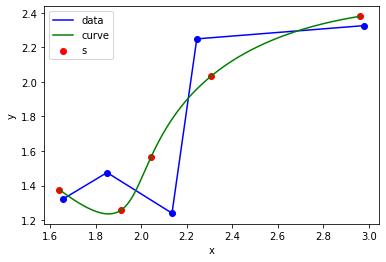

In [24]:
%matplotlib inline
    
def plot2D_curve_with_data(data, P, s):
    D = data[data[:, 2] >= 0]
    curve_points = makeSMatrix(s, 4)@P
    curve = makeSMatrix(np.linspace(s[0], s[-1], 1000), 4)@P
    
    plt.scatter(D[:, 0], D[:, 1], color="b")
    plt.plot(D[:, 0], D[:, 1], label="data", color="b")
    plt.plot(curve[:, 0], curve[:, 1], label="curve", color="g")
    plt.scatter(curve_points[:, 0], curve_points[:, 1], label="s", color="r")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()
    
plot2D_curve_with_data(D, PE, s)

It is clear initializing the vector equidistantly does not give the best estimation of $s$. Therefore, we will initialize the points based on relative the length to the curve formed by the datapoints and then try to improve our estimation of $s$. We can calculate the sum of squared errors to see this.

In [25]:
def SSE(data, P, s):
    D = data[data[:, 2] >= 0]
    S = makeSMatrix(s, 4)
    return np.sum(np.sum((D - (S@P))**2, axis=1), axis=0)

print(SSE(D, PE, s))

0.5226768180323474


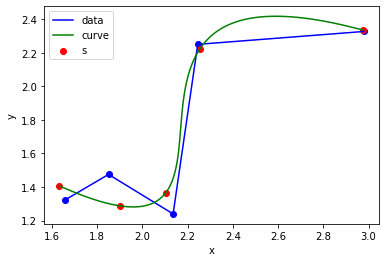

0.25452070449077013


In [26]:
diffs = (D[1:] - D[:-1])
distances = (diffs[:, 0]**2 + diffs[:, 1]**2)**(1/2)
distances = np.insert(distances, 0, 0)
cummulative_distances = np.cumsum(distances)
s2 = cummulative_distances/cummulative_distances[-1]

S2 = makeSMatrix(s2, 4)
PE2 = np.linalg.lstsq(S2, D, rcond=-1)[0]

plot2D_curve_with_data(D, PE2, s2)
print(SSE(D, PE2, s2))

In most cases, this clearly leads to a better fit. In addition to thies we can try improving this estimation of s. We do this by using a newton step on the following function:

$x'(s_i)(x_i − x(s_i)) + y'(s_i)(y_i − y(s_i)) = 0$.

This function is 0 when the direction of the derivative of the curve is orthogonal to the difference between the data point and the the datapoint estimation of the corresponding s. This would mean that this is indeed a good estimation of s, since that point the point on the curve that is closest to the datapoint we want to fit on.

Newton step is done by subracting the first derivative of this function divided by the second derivative of this function from $s_i$.

The first derivative is:
    
$(x_i - x(s_i))x''(s_i) + (y_i - y(s_i))y''(s_i) - x''(s_i)^2 - y''(s_i)^2$

This means the second derivative is:

$(x_i - x(s_i))x'''(s_i) + (y_i - y(s_i))y'''(s_i) - 2x'''(s_i)x''(s_i) - x'(s_i)x''(s_i) - 2y'''(s_i)y''(s_i) - y'(s_i)y''(s_i)$

In [27]:
def newton_step(data, P, s):
    D = data[data[:, 2] >= 0]
    S = makeSMatrix(s, 4)
    C = S@P

    P1d = P[1:, :] * [[1], [2], [3]]
    C1d = makeSMatrix(s, 3)@P1d # First derivates
    
    P2d = P1d[1:, :] * [[1], [2]]
    C2d = makeSMatrix(s, 2)@P2d # Second derivates
    
    P3d = P2d[1:, :]
    C3d = makeSMatrix(s, 1)@P3d # Third derivates
    
    N1 = (D[:, 0] - C[:, 0])*C2d[:, 0] + (D[:, 1] - C[:, 1])*C2d[:, 1]\
            - C2d[:, 0]**2 - C2d[:, 1]**2
    
    N2 = (D[:, 0] - C[:, 0])*C3d[:, 0] + (D[:, 1] - C[:, 1])*C3d[:, 1]\
            - 2*C3d[:, 0]*C2d[:, 0] - C1d[:, 0]*C2d[:, 0]\
            - 2*C3d[:, 1]*C2d[:, 1] - C1d[:, 1]*C2d[:, 1]
    
    s_new = np.copy(s)
    s_new[1:-1] -= (N1/N2)[1:-1] # Keep s=0 and s=1 in place.
    return s_new

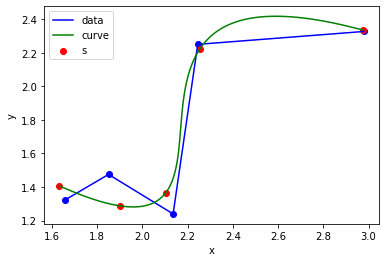

0.25452070449077013


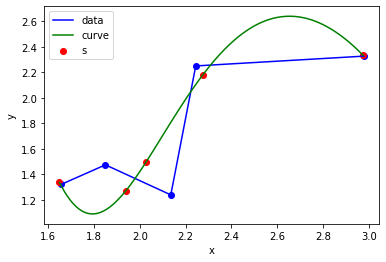

0.36502144839130946


In [28]:
s3 = newton_step(D, PE2, s2)
S3 = makeSMatrix(s3, 4)
PE3 = np.linalg.lstsq(S3, D, rcond=-1)[0]

plot2D_curve_with_data(D, PE2, s2)
print(SSE(D, PE2, s2))

plot2D_curve_with_data(D, PE3, s3)
print(SSE(D, PE3, s3))

This does not always converge, there for a check needs to be done if there is convergence or not.

When we have a fitted polynomial, we can use this polynomial to compute the control points for the bezier curve as follows.

In [29]:
def get_control_points(P):
    C = makeSMatrix(np.array([0, 1]), 4)@P
    p0 = C[0, :2]
    p3 = C[-1, :2]

    P1d = P[1:, :] * [[1], [2], [3]]
    C1d = makeSMatrix(np.array([0, 1]), 3)@P1d # First derivates

    p1 = p0 + (1/3) * C1d[0, :2]
    p2 = p3 - (1/3) * C1d[-1, :2]

    return [p0, p1, p2, p3]

The cubic Bezier curve is formally defined as:

$${\displaystyle \mathbf {B} (t)=(1-t)^{3}\mathbf {P} _{0}+3(1-t)^{2}t\mathbf {P} _{1}+3(1-t)t^{2}\mathbf {P} _{2}+t^{3}\mathbf {P} _{3},\ 0\leq t\leq 1.}$$

In [30]:
def bezier_curve(p0, p1, p2, p3, t):
    return ((1-t)**3 * p0) + (3*(1-t)**2*t * p1) + (3*(1-t)*t**2 * p2) + (t**3 * p3)

In the following graph both the polynomial and the Bezier curve dependent on the control points are visualized.

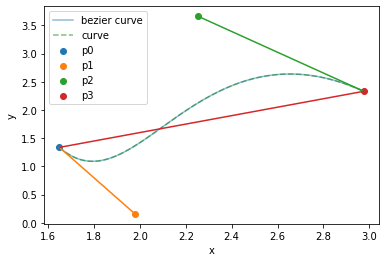

[1.64885508 1.33769458] [1.9783962  0.15774044] [2.25326644 3.66346143] [2.97611125 2.33225082]


In [31]:
p0, p1, p2, p3 = get_control_points(PE3) # Get associated controlpoints.
curve = makeSMatrix(np.linspace(0, 1, 1000), 4)@PE3

ts = np.linspace(0, 1, 100)

xs = []
ys = []
    
for t in ts:
    (x, y) = bezier_curve(p0, p1, p2, p3, t)
    xs.append(x)
    ys.append(y)

plt.plot(xs, ys, label="bezier curve", alpha=0.5)

plt.plot(curve[:, 0], curve[:, 1], label="curve", color="g", linestyle="--", alpha=0.5)

plt.scatter(p0[0], p0[1], label="p0")
plt.scatter(p1[0], p1[1], label="p1")
plt.plot([p0[0], p1[0]], [p0[1], p1[1]])

plt.scatter(p2[0], p2[1], label="p2")
plt.scatter(p3[0], p3[1], label="p3")
plt.plot([p2[0], p3[0]], [p2[1], p3[1]])

plt.plot([p0[0], p3[0]], [p0[1], p3[1]])

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

print(p0, p1, p2, p3)

We can use this to form the final shape we will feed into the network.

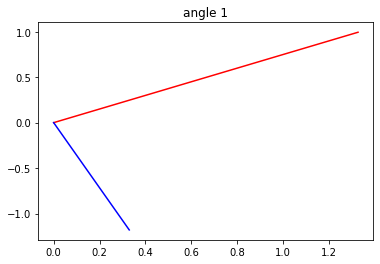

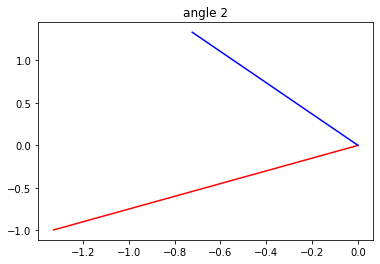

deg a1 111.24127054818008 1.9415264351675396
deg a2 98.34353934885777 1.7164185597021686


In [32]:
def parameterize_curve(P, p, debug=False):
    p0, p1, p2, p3 = get_control_points(P)
    
    vec_14 = p3 - p0 # Vec from controlpoint 1 to control point 4
    vec_41 = p0 - p3 # Vec from controlpoint 4 to control point 1
    
    distance_endpoints = np.sum((p3 - p0)**2)**(1/2)

    control_vec1 = p1 - p0
    control_vec2 = p2 - p3

    d1 = np.sum(control_vec1**2)**(1/2) / distance_endpoints
    d2 = np.sum(control_vec2**2)**(1/2) / distance_endpoints
    
    a1 = np.arctan2(
        control_vec1[0] * vec_14[1] - control_vec1[1] * vec_14[0],
        np.dot(vec_14, control_vec1)
    )
    
    a2 = np.arctan2(
        control_vec2[0] * vec_41[1] - control_vec2[1] * vec_41[0],
        np.dot(vec_41, control_vec2) # switched
    )

    if debug:
        plt.title("angle 1")
        plt.plot([0, vec_14[0]], [0, vec_14[1]], color="r")
        plt.plot([0, control_vec1[0]], [0, control_vec1[1]], color="b")
        plt.show()
    
        plt.title("angle 2")
        plt.plot([0, vec_41[0]], [0, vec_41[1]], color="r")
        plt.plot([0, control_vec2[0]], [0, control_vec2[1]], color="b")
        plt.show()

    return [vec_14[0], vec_14[1], d1, d2, a1, a2, P[1, 2], P[2, 2], P[3, 2], p, p]

res = parameterize_curve(PE3, 1, debug=True)

print("deg a1", (res[4] * 180) / np.pi, res[4])
print("deg a2", (res[5] * 180) / np.pi, res[5])

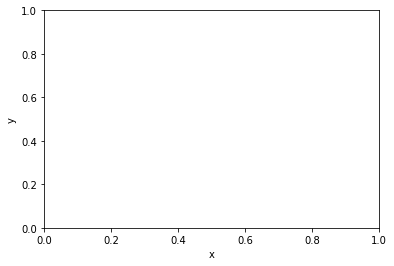

In [33]:
def make_rotation_matrix(angle):
    return np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])

def plot_bezier_curves(data):
    current_x = 0
    current_y = 0
    
    for i, (dx, dy, d1, d2, a1, a2, g1, g2, g3, p1, p2) in enumerate(data):
        if p2:
            current_x += dx
            current_y += dy
            continue
        
        p0 = np.array([current_x, current_y])
        p3 = np.array([current_x + dx, current_y + dy])
                
        p1 = make_rotation_matrix(a1) @ np.array([dx, dy]) * d1 + np.array([current_x, current_y])
        p2 = make_rotation_matrix(a2) @ np.array([-dx, -dy]) * d2 + np.array([current_x + dx, current_y + dy])
        
        plt.scatter(p0[0], p0[1])
        plt.scatter(p1[0], p1[1])
        plt.scatter(p2[0], p2[1])
        plt.scatter(p3[0], p3[1])
        plt.plot([p3[0], p2[0]], [p3[1], p2[1]])
        plt.plot([p0[0], p1[0]], [p0[1], p1[1]])
        
        ts = np.linspace(0, 1, 100)
        xs = []
        ys = []
    
        for t in ts:
            (x, y) = bezier_curve(p0, p1, p2, p3, t)
            xs.append(x)
            ys.append(y)
            
        current_x = p3[0]
        current_y = p3[1]
        
        plt.plot(xs, ys, label=f"Bezier {i}")
    
    plt.xlabel("x")
    plt.ylabel("y")
        
plot_bezier_curves([res])
plt.show()

We can combine this into a function that fits a curve to the given stroke and returns an estimation for the closest points and the estimated parameters. 

In [34]:
def get_relative_distances(data):
    diffs = (data[1:, :] - data[:-1, :])
    distances = np.insert((diffs[:, 0]**2 + diffs[:, 1]**2)**(1/2), 0, 0)
    cummulative_distances = np.cumsum(distances)
    return cummulative_distances/cummulative_distances[-1]

Initial fit 1.0953326655878832


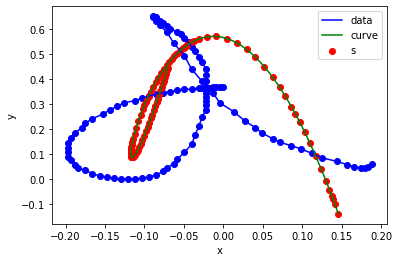

4.18506509646144


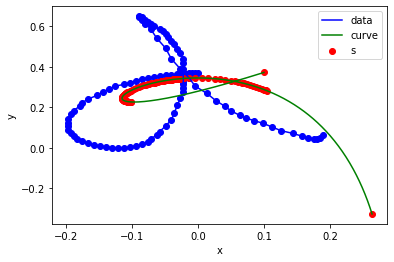

11.931651649170457


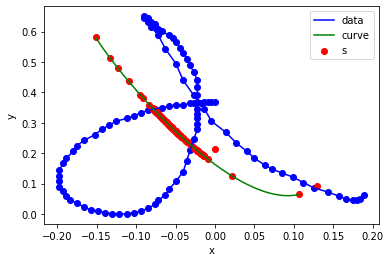

14.841224421269727


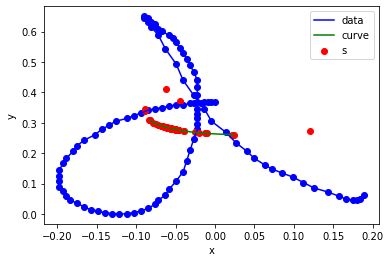

10.413506352065381


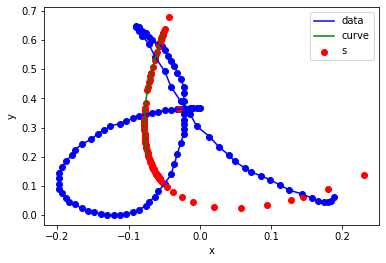

10.74994122127581


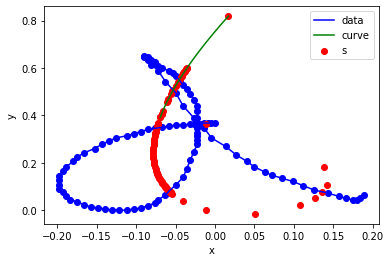

11.796677412060106


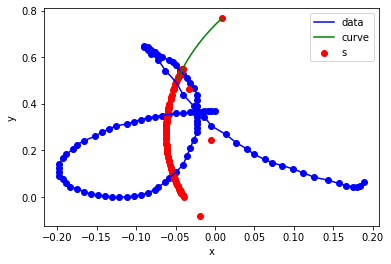

11.87718224881719


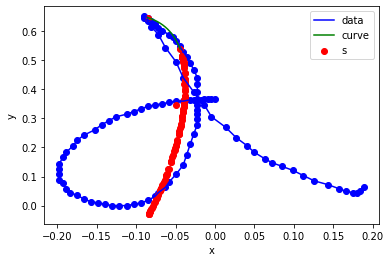

15.722598219374083


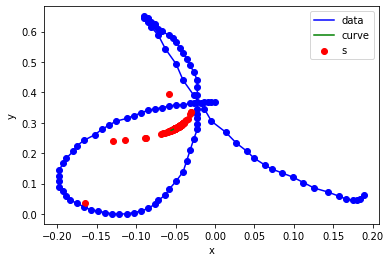

15.368067264613941


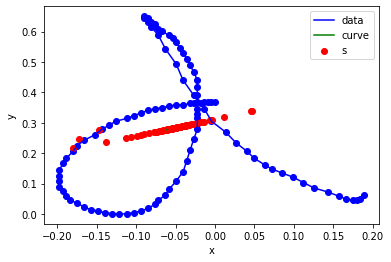

15.886815302520763


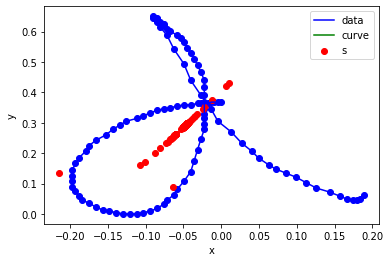

In [35]:
def fit_curve_newton_step(data, delta=0.05, precision=0.05, maxiter=10, debug=False):
    D = data[data[:, 2] >= 0]
    s = get_relative_distances(D)
    S = makeSMatrix(s, 4)
    PE = np.linalg.lstsq(S, D, rcond=None)[0]
    
    prev_error = SSE(D, PE, s)
    
    if debug:
        print("Initial fit", prev_error)
        plot2D_curve_with_data(D, PE, s)
    
    if prev_error < precision:
        return PE, s, prev_error
    
    for value in range(maxiter):
        s = newton_step(D, PE, s)
        S = makeSMatrix(s, 4)
        PE = np.linalg.lstsq(S, D, rcond=None)[0]
        
        error = SSE(D, PE, s)

        if debug:
            print(error)
            plot2D_curve_with_data(D, PE, s)

        if abs(error - prev_error) < delta:
            break

        prev_error = error
        
    return PE, s, prev_error

res = fit_curve_newton_step(normalized_timestamps[0], debug=True)

It is clear it is not possible to propely fit curves on this data, so we will need to split the data up. We do this by applying the procedure recursively and splitting up the point we are fitting if the fit is not good enough. This depends on two parameters. The fit is not good enough if the SSE is too large. The fit is also not good enough if the length of the curve is three times as long as the endpoint distances. We split the stroke up by looking at the three consecutive points with the smallest angle.

[2.35619449 3.14159265 3.14159265 2.67794504 2.9996956  3.14159265
 3.06482076 3.06176267 3.02844167 3.06068855 3.04753142 3.04753142
 3.07273616 3.09400955 3.03851105 3.03851105 3.11528294 2.98167953
 2.98167953 3.14159265 2.79856871 2.8753406  3.06482076 2.92292371
 2.9996956  3.14159265 3.14159265 2.8198421  2.35619449 2.35619449
 0.46364761 2.9996956  3.01723766 3.09400955 3.06482076 3.03851105
 3.14159264 3.03851105 3.01723766 3.09400955 2.92292371 3.14159265
 3.14159265 2.67794504 3.14159265 0.78539816 3.14159265 2.67794504
 2.8198421  2.97644398 2.97644398 2.9996956  3.11834103 2.84309372
 3.01723766 2.79856871 2.60117315 2.94419709 2.74680153 2.94419709
 2.35619449 3.14159265 2.35619449]


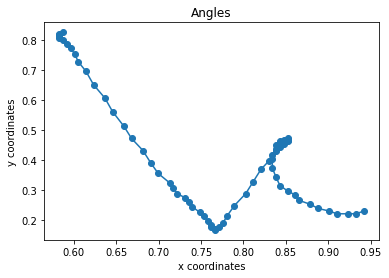

In [36]:
def length_vecs(vec):
    return (vec[:, 0]**2 + vec[:, 1]**2)**(1/2)

def dot_vecs(vec1, vec2):
    return vec1[:, 0]*vec2[:, 0] + vec1[:, 1]*vec2[:, 1]

def calc_angles(stroke):
    D = stroke[stroke[:, 2] >= 0]
    vecs_back = D[1:, :] - D[:-1, :]
    vecs_forward = D[:-1, :] - D[1:, :]

    frac = dot_vecs(vecs_forward[1:], vecs_back[:-1]) / (length_vecs(vecs_forward[1:]) * length_vecs(vecs_back[:-1]))
    
    # Prevent numerical errors
    frac[frac < -1] = -1
    frac[frac > 1] = 1
    
    return np.arccos(
                frac
            )

print(calc_angles(normalized_timestamps[2]))
plot_stroke(normalized_timestamps[2], "Angles")

Now we only need to split up each stroke.

78 28


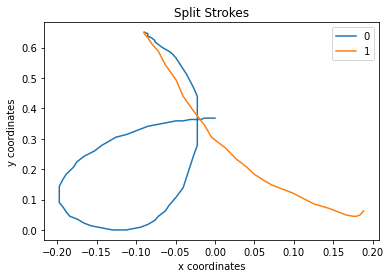

In [37]:
def split_datapoints(stroke):
    angles = calc_angles(stroke)
    indices = np.argsort(angles) + 1
    
    for index in indices:
        if 3 <= index and\
            index <= len(stroke[stroke[:,2]>=0]) - 3 and\
            len(stroke[stroke[:,2]>=0]) > 6: # Make sure there are enough datapoints to make the fit.
            return stroke[:index+1], stroke[index:]
    
    return None


a, b = split_datapoints(normalized_timestamps[0])
print(len(a), len(b))
plot_strokes([a, b], "Split Strokes")

In [38]:
def fit_datapoints(datapoints, precision=0.001):
    res = fit_curve_newton_step(datapoints)
    PE, s, error = res
    stdev = (error/len(datapoints))**(1/2)
    curves = []
    
    curve_diffs = (datapoints[1:, :] - datapoints[:-1, :]) # Smarter way to do this?
    distances = (curve_diffs[:, 0]**2 + curve_diffs[:, 1]**2)**(1/2)
    
    abs_diffs = datapoints[0] - datapoints[-1]
    abs_dist = (abs_diffs[0]**2 + abs_diffs[1]**2)**(1/2)
    
    if stdev > precision or (np.sum(distances) / abs_dist) > 3:
        split = split_datapoints(datapoints)
        
        if split:
            first_h, second_h = split
            res_f = fit_datapoints(first_h, precision)
            res_s = fit_datapoints(second_h, precision)
        
            if res_f:
                curves.extend(res_f)
            
            if res_s:
                curves.extend(res_s)
    else:
        curves.append([PE, s, stdev, datapoints])
        
    return curves

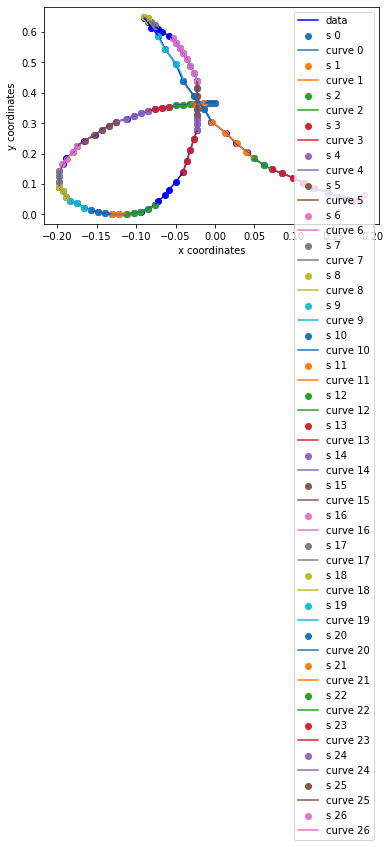

In [39]:
def plot_fitted_curves_with_data(curves, data):
    D = data[data[:, 2] >= 0]    
    plt.scatter(D[:, 0], D[:, 1], color="b")
    plt.plot(D[:, 0], D[:, 1], label="data", color="b")

    for i, (P, s, _, _) in enumerate(curves):
        curve_points = makeSMatrix(s, 4)@P
        curve = makeSMatrix(np.linspace(s[0], s[-1], 1000), 4)@P
        plt.scatter(curve_points[:, 0], curve_points[:, 1], label=f"s {i}")
        plt.plot(curve[:, 0], curve[:, 1], label=f"curve {i}")
        
    plt.xlabel("x coordinates")
    plt.ylabel("y coordinates")
    plt.legend()
    plt.show()

t = 0
fitted_curves = fit_datapoints(normalized_timestamps[t])
plot_fitted_curves_with_data(fitted_curves, normalized_timestamps[t])

In the last step we want to stitch the fitted curves back together, we will look at curves that are next to each other and see if we can fit a new curve containing these two curves.

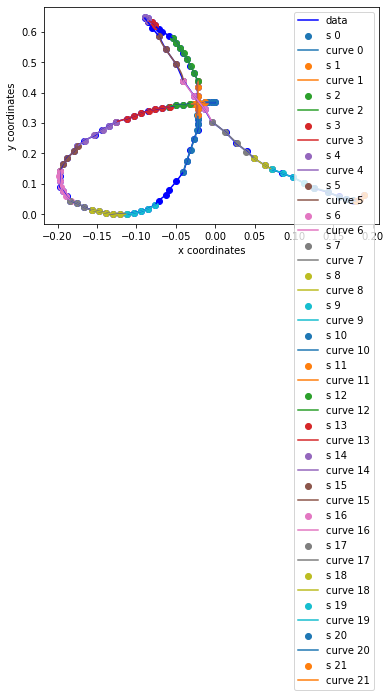

Original number of data points: 27
Number of datapoints after stitch with precision 0.001: 22


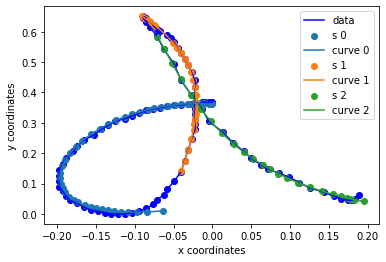

Original number of data points: 27
Number of datapoints after stitch with precision 0.01: 3


In [40]:
def stitch_curves(curves, precision=0.001):
    fitted_curves = curves.copy()
    curves = []
    
    for i, _ in enumerate(fitted_curves[:-1]):
        d = np.vstack((fitted_curves[i][3][:-1], fitted_curves[i+1][3]))
        PE, s, error = fit_curve_newton_step(d)
        stdev = (error/len(d))**(1/2)
        
        curve_diffs = (d[1:, :] - d[:-1, :])
        distances = (curve_diffs[:, 0]**2 + curve_diffs[:, 1]**2)**(1/2)
    
        abs_diffs = d[0] - d[-1]
        abs_dist = (abs_diffs[0]**2 + abs_diffs[1]**2)**(1/2)
    
        if stdev > precision or (np.sum(distances) / abs_dist) > 3:
            curves.append(fitted_curves[i])
            if i == len(fitted_curves) - 2:
                curves.append(fitted_curves[i+1])
        else:
            if i == len(fitted_curves) - 2:
                curves.append([PE, s, stdev, d])
            else:
                fitted_curves[i+1] = [PE, s, stdev, d]
                
    return curves

t = 0
stiched_curves = stitch_curves(fitted_curves, precision=0.001)
plot_fitted_curves_with_data(stiched_curves, normalized_timestamps[t])
print(f"Original number of data points: {len(fitted_curves)}\nNumber of datapoints after stitch with precision 0.001: {len(stiched_curves)}")

stiched_curves = stitch_curves(fitted_curves, precision=0.01)
plot_fitted_curves_with_data(stiched_curves, normalized_timestamps[t])
print(f"Original number of data points: {len(fitted_curves)}\nNumber of datapoints after stitch with precision 0.01: {len(stiched_curves)}")

Finally we combinde these into on function and parameterize the bezier curve.

In [41]:
def convert_stroke_to_bezier_curves(datapoints, precision=0.001, debug=False):
    if len(datapoints[datapoints[:, 2]>=0]) < 2:
        return None
    
    fitted_curves = fit_datapoints(datapoints)
    stiched_curves = stitch_curves(fitted_curves, precision=precision)
    
    parameters = [parameterize_curve(PE, 0) for (PE, s, stdev, d) in stiched_curves]
    
    if debug:
        plot_fitted_curves_with_data(stiched_curves, datapoints)
        plot_bezier_curves(parameters)
        plt.show()
    
    return parameters

(331, 4)


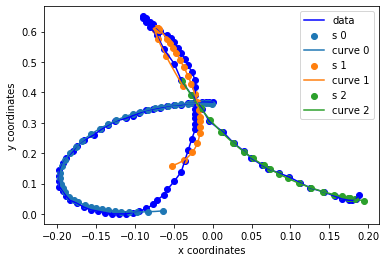

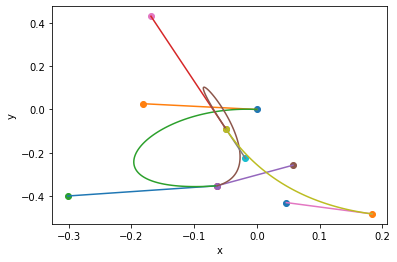

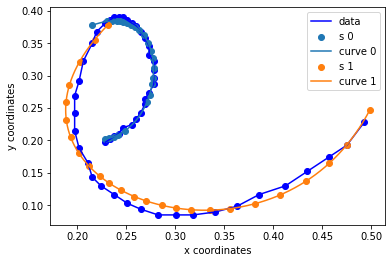

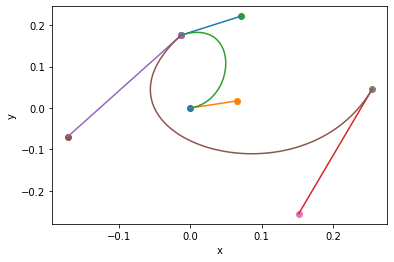

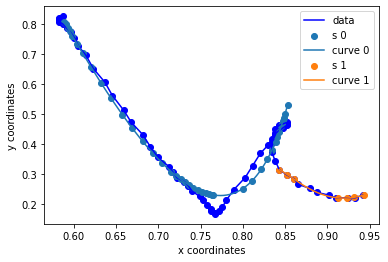

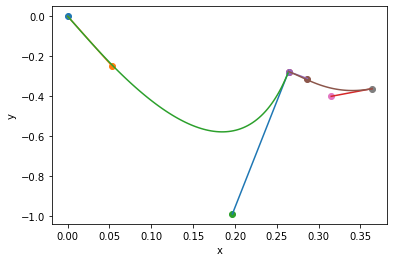

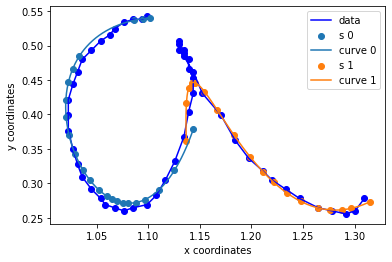

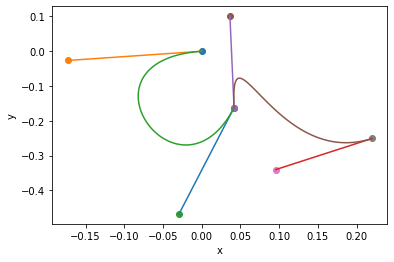

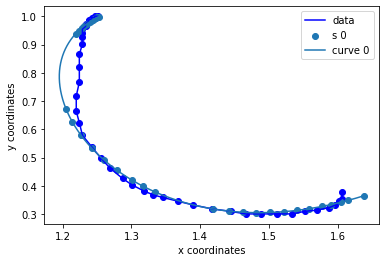

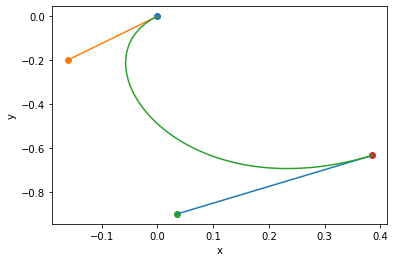

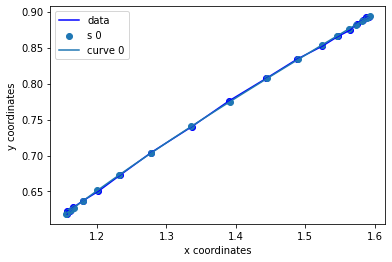

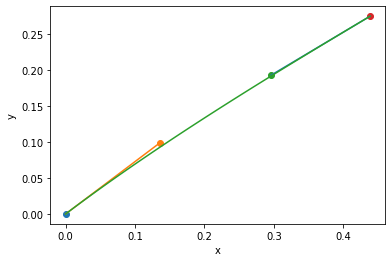

NameError: name 't1' is not defined

In [42]:
def strokes_to_bezier(strokes, precision=0.001, debug=False):
    normalized_strokes = scale_timestamps(normalize_strokes(strokes))
    points = []

    res = convert_stroke_to_bezier_curves(normalized_strokes[0], precision=precision, debug=debug)
    
    if res:
        res[0][9] = 1 # Indicate start of stroke
        points.extend(res)
    
    first = normalized_strokes[0]
    last_x = first[first[:, 2] >= 0][-1, 0]
    last_y = first[first[:, 2] >= 0][-1, 1]
 
    for stroke in normalized_strokes[1:]:
        res = convert_stroke_to_bezier_curves(stroke, precision=precision, debug=debug)
        
        current_x = stroke[stroke[:, 2] >= 0][0, 0]
        current_y = stroke[stroke[:, 2] >= 0][0, 1]
        
        dx = current_x - last_x
        dy = current_y - last_y
        
        last_x = stroke[stroke[:, 2] >= 0][-1, 0]
        last_y = stroke[stroke[:, 2] >= 0][-1, 1]
        
        if res:
            points.extend([[dx, dy, 0, 0, 0, 0, 0, 0, 0, 0, 1]]) # New starting point
            res[0][9] = 1 # Indicate start of stroke
            points.extend(res)
    
    return np.array(points)

print(rtps.shape)

# t1 = strokes_to_bezier(raw_strokes)
t2 = strokes_to_bezier(raw_strokes, precision=0.05, debug=True)

print(t1.shape)
print(t2.shape)

Depending on the precision, this representation takes a lot less memory.

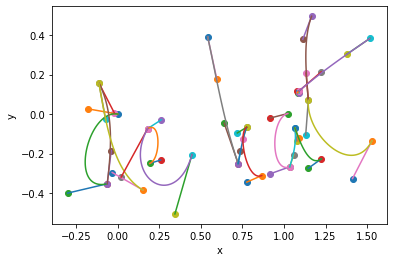

In [43]:
%matplotlib inline

p = strokes_to_bezier(raw_strokes, precision=0.01)
plot_bezier_curves(p)